In [13]:
import spacy
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=ea8833ddf3ce1128e4d4427e5d1aee27cb8e251777c792d1dfa013d1dbf164b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-n0t2z3ku/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [24]:
import json
import re
import time
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import en_core_web_lg
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [15]:
nlp = en_core_web_lg.load()

In [16]:
from google.colab import drive, files
drive.mount('/content/drive')

TRAIN_SENTENCES_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/baseline_dataset/sentences_train.txt"
DEV_SENTENCES_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/baseline_dataset/sentences_dev.txt"
TEST_SENTENCES_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/baseline_dataset/sentences_test.txt"

TRAIN_DEP_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/baseline_dataset/dep_train.txt"
DEV_DEP_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/baseline_dataset/dep_dev.txt"
TEST_DEP_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/baseline_dataset/dep_test.txt"

TRAIN_LABELS_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/baseline_dataset/labels_train.txt"
DEV_LABELS_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/baseline_dataset/labels_dev.txt"
TEST_LABELS_FILE_PATH = "/content/drive/MyDrive/Colab Notebooks/baseline_dataset/labels_test.txt"

MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/entity_model.pth"

Mounted at /content/drive


In [6]:
sentences = pd.read_csv(DEV_SENTENCES_FILE_PATH, delimiter='\t', header = None, names = ['sentence'])
sentences.head()

,sentence
0,put a credit card on a couch
1,move the credit card from the shelf to the sofa
2,move a credit card from a shelf to the couch
3,"turn around , go to the tall black shelves"
4,pick up the credit card on the shelf


In [6]:
len(sentences)

6379

In [18]:
# preprocess dependency parsing relations using one-hot encoding

# Collect all the dependency relations that occur in all the datasets
def collect_dep_relations(input_files):
    dep_set = set()
    
    for file in input_files:
        with open(file, "r") as f:
            for line in f:
                dep_list = line.split()
                for dep in dep_list:
                    dep_set.add(dep)

    return dep_set


# Transform the categorical column into their numerical counterparts, via the
# one-hot encoding scheme.
def create_dep_encoding(dep_set):
    ids = []
    id = 0
    dep_list = list(dep_set)

    for dep in dep_list:
        ids.append(id)
        id += 1
    
    df = pd.DataFrame(list(zip(ids, dep_list)), columns = ['Id', 'Dep'])
    dep_df = pd.get_dummies(df.Dep)

    return dep_df


# Return the vector of a dependency relation
# Ouput is a 41-dimensional vector
def get_dep_vector(dep_df, dep_string):

    try:
        return np.array(dep_df[dep_string].tolist(), dtype = np.float32)
    except KeyError as e:
        print("Error: Dependency relation not found")
        return None


In [19]:
# Global parameters
batchsize_global = 16

# assign each label with a unique index
roleset_size = 5
role_to_idx = {"O": 0, "B-TARGET": 1, "I-TARGET": 2, "B-RECEPTACLE": 3, 
              "I-RECEPTACLE": 4}

# collect the dependency relation set, and represent each dep relation using 
# one-hot encoding
dep_set = collect_dep_relations({TRAIN_DEP_FILE_PATH, DEV_DEP_FILE_PATH, TEST_DEP_FILE_PATH})
dep_df = create_dep_encoding(dep_set)
# root_vector = get_dep_vector(dep_df, 'ROOT')
print("Number of dependency relations:", len(dep_set))

depset_size = 41
embedding_dim = 300

# parameters used in EntityLinker model
feature_dimension = depset_size + embedding_dim
hidden_dimension = 50

Number of dependency relations: 41


In [ ]:
print(dep_df)

    ROOT  acl  acomp  advcl  advmod  ...  prt  punct  quantmod  relcl  xcomp
0      0    0      1      0       0  ...    0      0         0      0      0
1      0    0      0      0       0  ...    0      0         0      0      0
2      0    0      0      0       0  ...    0      0         0      0      0
3      0    0      0      0       0  ...    0      0         0      0      0
4      0    0      0      0       0  ...    0      0         0      0      0
5      0    0      0      0       0  ...    0      0         0      0      0
6      0    0      0      0       0  ...    1      0         0      0      0
7      0    0      0      0       0  ...    0      0         0      0      0
8      0    0      0      0       0  ...    0      0         0      0      0
9      0    0      0      0       0  ...    0      0         0      0      0
10     1    0      0      0       0  ...    0      0         0      0      0
11     0    1      0      0       0  ...    0      0         0      0      0

maybe using segment id as a feature?

In [20]:
#Initialising the dataset using pytorch
class ELDataset(Dataset):

    def __init__(self, nlp_model, sentence_file, dep_file, label_file):
        self.nlp = nlp_model
        self.sentence_file = pd.read_csv(sentence_file, delimiter='\t', 
                                     header = None, names = ['sentence'])
        self.dep_file = pd.read_csv(dep_file, delimiter='\t', 
                                    header = None, names = ['dependency'])
        self.label_file = pd.read_csv(label_file, delimiter='\t', 
                                      header = None, names = ['label'])
        self.feature_dim = depset_size + embedding_dim

    def __len__(self):
        assert len(self.sentence_file) == len(self.dep_file)
        assert len(self.sentence_file) == len(self.dep_file)
        return len(self.sentence_file)
    
    # ouput is a 300-dimensional vector (numpy.array)
    def get_spacy_embedding(self, token_string):
        token = token_string.lower()
        minimum_n_gram_len = 1

        # if the word has a vector, the result is the pre-trained vector;
        # if the word is out of vocabulary, then the resulting vector uses 
        # FastText’s subword features by average over n-grams of orth
        if self.nlp.vocab.has_vector(token):
            vector = self.nlp.vocab.get_vector(token)
        else:
            vector = self.nlp.vocab.get_vector(token, minn = minimum_n_gram_len)
        
        return vector
    
    # concatenate word embedding (300d) with dependency relation (41d)
    # output is a 341 dimensional feature (numpy.array)
    def prepare_token_feature(self, token_string, dep_string):
        vector = self.get_spacy_embedding(token_string)
        dep = get_dep_vector(dep_df, dep_string)
        token_feature = np.append(vector, dep)
        
        return token_feature
    
    # get the numerical value of the labels
    # return the a numpy array of labels for a sentence
    def prepare_labels(self, label_list, role_to_idx):
        ids = [role_to_idx[role] for role in label_list]
        return np.array(ids)
    
    
    def __getitem__(self, index):
        
        desc = self.sentence_file.loc[index, 'sentence'].split()
        dep = self.dep_file.loc[index, 'dependency'].split()
        label = self.label_file.loc[index, 'label'].split()

        token_count = len(desc)
        tensor_shape = (token_count, self.feature_dim,)
        sentence_tensor = torch.zeros(tensor_shape)

        token_idx = 0
        for token in desc:
            token_feature = self.prepare_token_feature(token, dep[token_idx])
            token_f_tensor = torch.from_numpy(token_feature).float()
            sentence_tensor[token_idx] = token_f_tensor
            token_idx += 1

        # print(sentence_tensor.shape)

        label_array = self.prepare_labels(label, role_to_idx)
        label_tensor = torch.from_numpy(label_array)

        return sentence_tensor, label_tensor


In [23]:
# In a batch of the sentences, sequences have variable length, so we need to
# pad them to the same size
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    # x_lens_t = torch.tensor([len(x) for x in xx])
    # y_lens_t = torch.tensor([len(y) for y in yy])

    x_lens = [len(x) for x in xx]
    y_lens = [len(y) for y in yy]

    padding_tensor = 0
    # the label for the pad token is -1
    padding_label = -1

    xx_pad = pad_sequence(xx, batch_first = True, padding_value = padding_tensor)
    yy_pad = pad_sequence(yy, batch_first = True, padding_value = padding_label)

    return xx_pad, yy_pad, x_lens, y_lens

In [11]:
# create the dataset for training, validation and testing
train_set = ELDataset(nlp_model = nlp, sentence_file = TRAIN_SENTENCES_FILE_PATH, 
                      dep_file = TRAIN_DEP_FILE_PATH, 
                      label_file = TRAIN_LABELS_FILE_PATH)

dev_set = ELDataset(nlp_model = nlp, sentence_file = DEV_SENTENCES_FILE_PATH, 
                    dep_file = DEV_DEP_FILE_PATH, 
                    label_file = DEV_LABELS_FILE_PATH)

test_set = ELDataset(nlp_model = nlp, sentence_file = TEST_SENTENCES_FILE_PATH, 
                     dep_file = TEST_DEP_FILE_PATH, 
                     label_file = TEST_LABELS_FILE_PATH)

# Load the dataset
train_loader = DataLoader(train_set, batch_size = batchsize_global, 
                          shuffle=False, pin_memory=True, 
                          collate_fn = pad_collate)

dev_loader = DataLoader(dev_set, batch_size = batchsize_global, 
                        shuffle=False, pin_memory=True, 
                        collate_fn = pad_collate)

test_loader = DataLoader(test_set, batch_size = batchsize_global, 
                         shuffle=False, pin_memory=True, 
                         collate_fn = pad_collate)

print("Done loading datasets.")

Done loading datasets.


In [25]:
class EntityLinker(nn.Module):
    
    def __init__(self, feature_dim, hidden_dim, roleset_size):
        super(EntityLinker, self).__init__()
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.roleset_size = roleset_size

        self.lstm = nn.LSTM(self.feature_dim, self.hidden_dim, batch_first=True)
        self.cls_layer = nn.Linear(self.hidden_dim, self.roleset_size)
    
    def forward(self, input_features, input_lens):
        
        input_packed = pack_padded_sequence(input_features, 
                                            input_lens, batch_first = True, 
                                            enforce_sorted = False)
        
        # print("input packed shape:", input_packed.batch_sizes)
        lstm_out_packed, _ = self.lstm(input_packed)
        # print("output packed shape:", lstm_out_packed.batch_sizes)
        
        # lstm_out_padded shape: batch size x batch_max_len x lstm_hidden_dim
        lstm_out_padded, output_lengths = pad_packed_sequence(lstm_out_packed, 
                                                              batch_first = True)

        # label_out size: batch_size x batch_max_len x roleset_size
        label_out = self.cls_layer(lstm_out_padded)        

        
        # label_scores = F.log_softmax(label_out, dim=2)
        # # print(label_scores.shape)
        
        # # flatten_output size: batch_size*batch_max_len x roleset_size
        # flatten_output = label_scores.view(-1, label_scores.shape[2])
        # # print(flatten_output.shape)
        
        # return label_scores
        return label_out

In [13]:
gpu = 0

In [26]:
# Run the entity linker on GPU
model = EntityLinker(feature_dim = feature_dimension, 
                     hidden_dim = hidden_dimension, 
                     roleset_size = roleset_size)
model.cuda(gpu)
print("Done creating the entity linker")

Done creating the entity linker


In [15]:
optimizer = optim.Adam(model.parameters(), lr = 2e-3)

In [16]:
# calculate the cross entropy loss
def loss_fn(output_padded, labels, num_tokens):
    
    batch_ce_loss = 0.0
    
    for i in range(output_padded.size(0)):
        ce_loss = F.cross_entropy(output_padded[i], labels[i], reduction="sum", ignore_index=-1)
        batch_ce_loss += ce_loss
    
    loss = batch_ce_loss/num_tokens

    return loss

In [17]:
def get_accuracy_from_scores(label_scores, label):
    role_scores = F.log_softmax(label_scores, dim=2)
    flatten_scores = role_scores.view(-1, label_scores.shape[2])

    flatten_labels = label.view(-1)
    mask = (flatten_labels >= 0).float()
    total_token = int(torch.sum(mask))

    correct_pred = 0
    all_preds = torch.tensor([])

    for i in range(flatten_labels.shape[0]):
        pred = torch.argmax(flatten_scores[i])
        
        if (flatten_labels[i] >= 0):
            pred_dim1 = torch.tensor([pred.item()])
            # print(pred_dim1.shape)
            all_preds = torch.cat((all_preds, pred_dim1), dim=0)
            if (flatten_labels[i] == pred):
                correct_pred += 1

    acc = correct_pred / total_token
    # print(all_preds.shape, total_token)
    return acc, all_preds

In [18]:
def evaluate(model, dev_loader, gpu):
    model.eval()

    mean_acc = 0
    count = 0
    all_preds = torch.tensor([])
    
    with torch.no_grad():
        for batch in dev_loader:
            x_padded, labels_padded, x_lens, labels_lens = batch
            input = x_padded.cuda(gpu)
            label = labels_padded.cuda(gpu)
            input_lens = x_lens
            label_lens = labels_lens

            label_scores = model(input, input_lens)
            acc, batch_preds = get_accuracy_from_scores(label_scores, label)
            all_preds = torch.cat((all_preds, batch_preds), dim=0)
            mean_acc += acc
            count += 1
    
    return mean_acc/count, all_preds


In [19]:
def train(model, loss_fn, optimizer, train_loader, dev_loader, max_eps, gpu):

    st = time.time()
    
    for ep in range(max_eps):
        model.train()
        for iter, batch in enumerate(train_loader):
            optimizer.zero_grad()

            x_padded, labels_padded, x_lens, labels_lens = batch
            input = x_padded.cuda(gpu)
            label = labels_padded.cuda(gpu)
            input_lens = x_lens
            label_lens = labels_lens

            label_scores = model(input, input_lens)
            loss = loss_fn(label_scores, label, sum(label_lens))
            
            loss.backward()
            optimizer.step()
            
            if iter % 100 == 0:
                acc, all_preds = get_accuracy_from_scores(label_scores, label)
                print("Iteration {} of epoch {} complete, Loss: {}; Accuracy: {}; Time taken (s): {}"
                    .format(iter, ep, loss.item(), acc, (time.time()-st)))
                st = time.time()
        
        dev_acc, dev_preds = evaluate(model, dev_loader, gpu)
        print("Epoch {} complete! Development Accuracy: {};".format(ep, dev_acc))
    
    return None

In [20]:
num_epoch = 2
train(model, loss_fn, optimizer, train_loader, dev_loader, num_epoch, gpu)

Iteration 0 of epoch 0 complete, Loss: 1.7350932359695435; Accuracy: 0.023255813953488372; Time taken (s): 0.08262777328491211
Iteration 100 of epoch 0 complete, Loss: 0.33863312005996704; Accuracy: 0.9073170731707317; Time taken (s): 3.427889347076416
Iteration 200 of epoch 0 complete, Loss: 0.21479085087776184; Accuracy: 0.9442231075697212; Time taken (s): 3.5166842937469482
Iteration 300 of epoch 0 complete, Loss: 0.10061050951480865; Accuracy: 0.9672727272727273; Time taken (s): 3.3506863117218018
Iteration 400 of epoch 0 complete, Loss: 0.10973016172647476; Accuracy: 0.9721030042918455; Time taken (s): 3.425360679626465
Iteration 500 of epoch 0 complete, Loss: 0.0772830918431282; Accuracy: 0.9816272965879265; Time taken (s): 3.4060721397399902
Iteration 600 of epoch 0 complete, Loss: 0.13127762079238892; Accuracy: 0.9567567567567568; Time taken (s): 3.4984827041625977
Iteration 700 of epoch 0 complete, Loss: 0.051655665040016174; Accuracy: 0.9819819819819819; Time taken (s): 3.551

## Performance on test set

In [3]:
def get_dataset_labels(test_loader):
    all_labels = torch.tensor([])
    
    for batch in test_loader:
        x_padded, labels_padded, x_lens, labels_lens = batch
        flatten_labels = labels_padded.view(-1)
        mask = (flatten_labels >= 0).float()
        total_token = int(torch.sum(mask))

        for i in range(flatten_labels.shape[0]):
            if (flatten_labels[i] >= 0):
                label_dim1 = torch.tensor([flatten_labels[i].item()])
                all_labels = torch.cat((all_labels, label_dim1), dim=0)
    
    # print(all_labels.shape)
    return all_labels


In [8]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

def plot_confusion_matrix(cm, classes, normalize=False, 
                          title = "Confusion Matrix", cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    accuracy = np.trace(cm) / float(np.sum(cm))

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}'.format(accuracy))


IndentationError: ignored

In [5]:
# accuracy on test dataset

test_acc, test_preds = evaluate(model, test_loader, gpu)
print("test accuracy: ", test_acc)

NameError: ignored

[[134317    425     51    505    175]
 [   337   4277     41     21      0]
 [   100      3   1306      0     10]
 [  1530     38      1   1063      3]
 [   273      0     40      7    263]]
Confusion matrix, without normalization


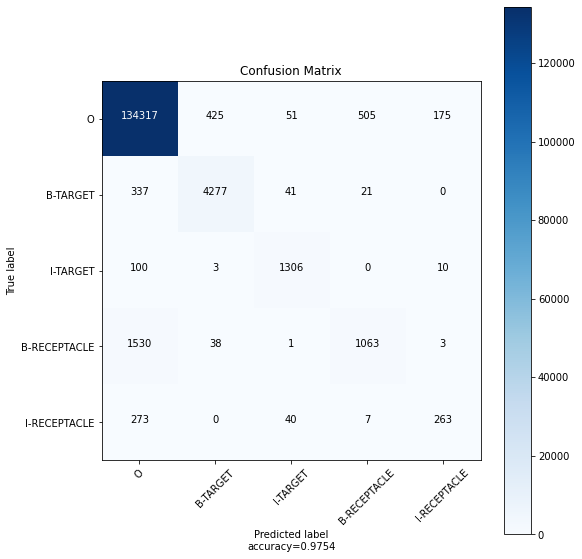

In [27]:
# shape: total number of tokens in the dataloader
test_labels = get_dataset_labels(test_loader)

cm = confusion_matrix(test_labels, test_preds)
print(cm)

classes_name = list(role_to_idx)
plot_confusion_matrix(cm, classes_name)

In [2]:
print('Precision: %.3f' % precision_score(test_labels, test_preds))
print(classification_report(test_labels, test_preds, target_names=classes_names))

NameError: ignored

## Save and load model

In [163]:
# save the model
model_save_name = 'entity_model.pth'
model_save_path = F"/content/drive/MyDrive/Colab Notebooks/{model_save_name}"
torch.save(model.state_dict(), model_save_path)

# download the model to the local drive
# files.download(model_save_path) 

In [28]:
# load the saved model from google drive
model_load = EntityLinker(feature_dim = feature_dimension, 
                     hidden_dim = hidden_dimension, 
                     roleset_size = roleset_size)
model_load.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))
# model_load.cuda(gpu)

<All keys matched successfully>

## process a single sentence

In [32]:
def idx_to_label(preds, role_to_idx):
    preds_string = []
    for result in preds:
        role = list(role_to_idx.keys())[list(role_to_idx.values()).index(result)]
        preds_string.append(role)
    return preds_string


def process_sentence(nlp, sentence_string):
    sentence_nlp = nlp(sentence_string.lower())

    num_token = len(sentence_nlp)
    tensor_shape = (num_token, feature_dimension)
    tokens_features_t = torch.zeros(tensor_shape)

    i = 0
    for token in sentence_nlp:
        dep = get_dep_vector(dep_df, token.dep_)
        vector = token.vector
        feature = np.append(vector, dep)
        feature_tensor = torch.from_numpy(feature).float()
        tokens_features_t[i] = feature_tensor
        i += 1

    return tokens_features_t
       

def predict(model, nlp, sentence_string, role_to_idx):
    
    model.eval()
    features_t = process_sentence(nlp, sentence_string)
    input_lens = features_t.shape[0]

    input = features_t[None, :, :]
    predictions = []

    with torch.no_grad():
        label_scores = model(input, [input_lens])
        role_scores = F.log_softmax(label_scores, dim=2)
        flatten_scores = role_scores.view(-1, label_scores.shape[2])

        for i in range(input_lens):
            pred = torch.argmax(flatten_scores[i])
            
            predictions.append(pred.item())
        
        pred_roles = idx_to_label(predictions, role_to_idx)
    return pred_roles


In [30]:
def get_target_and_recep(sentence_nlp, pred_roles):
    target = []
    receptacle = []

    i = 0    
    for label in pred_roles:
        token = sentence_nlp[i].text
        if label == 'B-TARGET':
            target.append(token)
        elif label == 'I-TARGET':
            item = target[-1] + ' ' + token
            target[-1] = item
        elif label == 'B-RECEPTACLE':
            receptacle.append(token)
        elif label == 'I-RECEPTACLE':
            item = receptacle[-1] + ' ' + token
            receptacle[-1] = item
        i += 1
    
    return target, receptacle


In [38]:
sentence = "move the pillow to the chair and turn to the couch and "
sentence_nlp = nlp(sentence.lower())

result = predict(model_load, nlp, sentence, role_to_idx)
print(result)
target, receptacle = get_target_and_recep(sentence_nlp, result)
print("target:     {} \nreceptacle: {}".format(target, receptacle))


['O', 'O', 'B-TARGET', 'O', 'O', 'B-RECEPTACLE', 'O', 'O', 'O', 'O', 'O', 'O']
target:     ['pillow'] 
receptacle: ['chair']
